In [1]:
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader

from evidential import LinearNormalGamma, evidential_regresssion_loss

import yaml
import pandas as pd
from collections import defaultdict
import random, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from scipy.stats import pearsonr
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
%matplotlib inline

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True

In [4]:
seed = 1000

In [5]:
seed_everything(seed)

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

In [7]:
#deepCONUS: /glade/p/cisl/aiml/ai2es/deepconus/
#GEFS_Bias: /glade/p/cisl/aiml/ksha/AI2ES/
#Surface Layer (Idaho): /glade/p/cisl/aiml/fasteddy/idaho_derived_data_20210720.csv
#Surface Layer (Cabauw): /glade/p/cisl/aiml/fasteddy/cabauw_derived_data_20210720.csv

In [8]:
input_cols = [
    'wind_speed:10_m:m_s-1',
    'potential_temperature_skin_change:10_m:K_m-1',
    'bulk_richardson:10_m:None',
    'mixing_ratio_skin_change:2_m:g_kg-1_m-1'
]
output_cols = [
    #"friction_velocity:surface:m_s-1",
    "kinematic_sensible_heat_flux:surface:K_m_s-1",
    #"kinematic_latent_heat_flux:surface:g_kg-1_m_s-1"
]

In [9]:
idaho = pd.read_csv("/glade/p/cisl/aiml/fasteddy/idaho_derived_data_20210720.csv")
cabauw = pd.read_csv("/glade/p/cisl/aiml/fasteddy/cabauw_derived_data_20210720.csv")

In [10]:
# Get the shapes of the input and output data 
input_size = len(input_cols)
middle_size = 4500
output_size = 1

batch_size = 256

L1_penalty = 0.0
L2_penalty = 0.0
dropout = 0.0

lr_patience = 15
stopping_patience = 25
learning_rate = 1e-5
clip = 1.0

loss_coeff = 0.05

### Use Idado as example until a config file is used

In [148]:
train_data, rest_data = train_test_split(idaho, train_size=0.8, random_state = seed)
valid_data, test_data = train_test_split(rest_data, test_size=0.5, random_state = seed)

In [130]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()

In [131]:
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

In [132]:
#y_train = train_data[output_cols].to_numpy()
#y_valid = valid_data[output_cols].to_numpy()
#y_test  = test_data[output_cols].to_numpy()

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

In [133]:
train_split = TensorDataset(
    torch.from_numpy(x_train).float(),
    torch.from_numpy(y_train).float()
)
train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True, num_workers=0)

valid_split = TensorDataset(
    torch.from_numpy(x_valid).float(),
    torch.from_numpy(y_valid).float()
)
valid_loader = DataLoader(valid_split, batch_size=batch_size, shuffle=False, num_workers=0)

### Load an MLP model and optimizer

In [16]:
def load_model():
    model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_size, middle_size)),
            #nn.BatchNorm1d(middle_size),
            nn.Dropout(dropout),
            nn.LeakyReLU(),
            #nn.Tanh(),
            LinearNormalGamma(middle_size, output_size)
    )
    return model

def initialize_weights(m):
    if type(m) in [nn.Linear]:
        nn.init.xavier_uniform_(m.weight)
        #nn.init.xavier_uniform_(model.bias)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d or nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
model = load_model()
model = model.apply(initialize_weights).to(device)

In [46]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = L2_penalty,
                             eps = 1e-7,
                             betas = (0.9, 0.999),
                             amsgrad = False)

#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-2*learning_rate)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        patience = lr_patience, 
        verbose = True,
        min_lr = 1.0e-13
)

In [47]:
print_every = 25

In [48]:
results_dict = defaultdict(list)

for epoch in range(1000):
    
    # Train in batch mode
    model.train()
    
    train_loss = []
    for k, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        
        loss = evidential_regresssion_loss(y.to(device), model(x.to(device)), loss_coeff)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss += L1_penalty * l1_norm
        loss += L2_penalty * l2_norm
        train_loss.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if not np.isfinite(loss.item()):
            print(x)
            raise
        
    # Validate 
    model.eval()
    with torch.no_grad():
        
        # Validate in batch mode
        mae_loss = []
        valid_loss = []
        for k, (x, y) in enumerate(valid_loader):
            pred = model(x.to(device))
            loss = evidential_regresssion_loss(y.to(device), pred, loss_coeff)
            mae = torch.nn.L1Loss()(y.to(device), pred[0])
            valid_loss.append(loss.item())
            mae_loss.append(mae.item())
            
    if not np.isfinite(np.mean(valid_loss)):
        break
        
    results_dict["epoch"].append(epoch)
    results_dict["train_nll"].append(np.mean(train_loss))
    results_dict["val_nll"].append(np.mean(valid_loss))
    results_dict["val_mae"].append(np.mean(mae_loss))
    results_dict["lr"].append(optimizer.param_groups[0]['lr'])
    
    # Save the dataframe to disk
    df = pd.DataFrame.from_dict(results_dict).reset_index()
    df.to_csv(f"surfacelayer/training_log.csv", index = False)
    
    if epoch % print_every == 0:
        print(f'Epoch {epoch} train_nll {results_dict["train_nll"][-1]:4f}', 
              f'val_nll {results_dict["val_nll"][-1]:4f}',
              f'val_mae {results_dict["val_mae"][-1]:4f}',
              f'lr {results_dict["lr"][-1]}'
             )
        
    metric = 'val_mae'

    # anneal the learning rate using just the box metric
    lr_scheduler.step(results_dict[metric][-1])
    
    if results_dict[metric][-1] == min(results_dict[metric]):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': min(results_dict[metric])
        }
        torch.save(state_dict, f"surfacelayer/mlp.pt")
    
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(results_dict[metric]) if j == min(results_dict[metric])][0]
    offset = epoch - best_epoch
    if offset >= stopping_patience:
        break
        
best_epoch = [i for i,j in enumerate(results_dict[metric]) if j == min(results_dict[metric])][0]
print(f'Best epoch {best_epoch} train_nll {results_dict["train_nll"][best_epoch]:4f}', 
      f'val_nll {results_dict["val_nll"][best_epoch]:4f}',
      f'val_mae {results_dict["val_mae"][best_epoch]:4f}',
      f'lr {results_dict["lr"][best_epoch]}')

Epoch 0 train_nll 1.543063 val_nll 1.534539 val_mae 0.764076 lr 1e-05
Epoch 25 train_nll 0.707465 val_nll 0.726205 val_mae 0.370412 lr 1e-05
Epoch 50 train_nll 0.494852 val_nll 0.543879 val_mae 0.343202 lr 1e-05
Epoch    54: reducing learning rate of group 0 to 1.0000e-06.
Best epoch 37 train_nll 0.552247 val_nll 0.555118 val_mae 0.340510 lr 1e-05


### Predict on the holdout split and make some plots

In [19]:
model = load_model().to(device)

In [20]:
checkpoint = torch.load(
    "surfacelayer/mlp.pt",
    map_location=lambda storage, loc: storage
)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

Sequential(
  (0): Linear(in_features=4, out_features=4500, bias=True)
  (1): Dropout(p=0.0, inplace=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): LinearNormalGamma(
    (linear): Linear(in_features=4500, out_features=4, bias=True)
  )
)

In [149]:
with torch.no_grad():
    test_input = torch.from_numpy(x_test).float()
    y_pred = model(test_input.to(device))

In [150]:
test_data["mu"] = y_scaler.inverse_transform(y_pred[0].cpu().numpy())
test_data["v"] = y_pred[1].cpu().numpy()
test_data["alpha"] = y_pred[2].cpu().numpy()
test_data["beta"] = y_pred[3].cpu().numpy()
test_data["var"] = y_scaler.inverse_transform(np.sqrt(test_data["beta"]  / (test_data["v"] * (test_data["alpha"] - 1))))

In [151]:
test_data["error"] = np.abs(test_data["mu"] - test_data[output_cols[0]])

In [152]:
#test_data

In [153]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [154]:
test_data["mape"] = mape(test_data["mu"], test_data[output_cols[0]])

Pearson: 0.8881529444836085
MAPE: 451.8457384050614


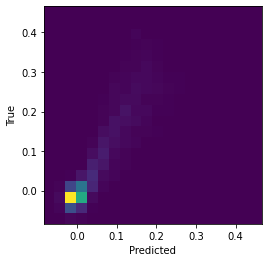

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111)

minx = test_data[output_cols[0]].min()
maxx = test_data[output_cols[0]].max()

_ = ax.hist2d(test_data["mu"], test_data[output_cols[0]], bins = 20, range = [[minx, maxx], [minx, maxx]], cmin = 1)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_aspect('equal', adjustable='box')

print(
    "Pearson:", pearsonr(test_data["mu"], test_data[output_cols[0]])[0])
print(
    "MAPE:", mape(test_data["mu"], test_data[output_cols[0]]))

Pearson: 0.49913232606721575
MAPE: 72.5135979376706


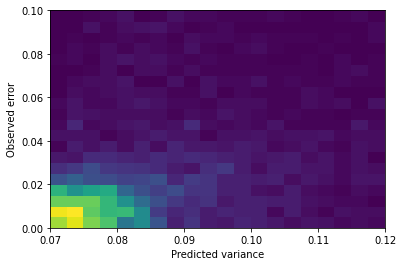

In [156]:
fig = plt.figure()
ax = fig.add_subplot(111)

minx = min(test_data["var"].min(), test_data["error"].min())
maxx = max(test_data["var"].max(), test_data["error"].max())

_ = ax.hist2d(test_data["var"], test_data["error"], bins = 20, range = [[0.07, 0.12], [0.0, 0.1]])
ax.set_xlabel("Predicted variance")
ax.set_ylabel("Observed error")
#ax.set_aspect('equal', adjustable='box')

print(
    "Pearson:", pearsonr(test_data["var"], test_data["error"])[0])
print(
    "MAPE:", mape(test_data["var"], test_data["error"]))

In [157]:
#test_data.sort_values("var").plot("error", "var")

In [158]:
test_data = test_data.sort_values("var", ascending = True)

In [159]:
test_data["dummy"] = 1
test_data["cu_mae"] = test_data["error"].cumsum() / test_data["dummy"].cumsum()
test_data["cu_mape"] = test_data["mape"].cumsum() / test_data["dummy"].cumsum()
test_data["cu_var"] = test_data["var"].cumsum() / test_data["dummy"].cumsum()
test_data["var_cov"] = 1 - test_data["dummy"].cumsum() / len(test_data)

(0.005, 0.06)

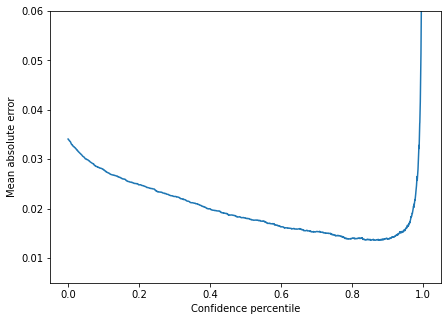

In [160]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(test_data["var_cov"], test_data["cu_mae"])
#ax.plot(test_data["coverage"], test_data["MAPE"])

ax.set_xlabel("Confidence percentile")
ax.set_ylabel("Mean absolute error")

ax.set_ylim([0.005, 0.06])

In [162]:
test_data[["error", "var", "cu_mae", "cu_var", "var_cov"]].head(10)

,error,var,cu_mae,cu_var,var_cov
28,0.715636,0.051491,0.715636,0.051491,0.999731
2,0.418359,0.061251,0.566997,0.056371,0.999462
14691,0.008250,0.066857,0.380748,0.059867,0.999193
9002,0.003470,0.066928,0.286429,0.061632,0.998924
23316,0.003990,0.067099,0.229941,0.062725,0.998655
21207,0.004202,0.067124,0.192318,0.063459,0.998386
28347,0.000833,0.067378,0.164963,0.064018,0.998117
9001,0.006753,0.067502,0.145187,0.064454,0.997848
18720,0.006713,0.067571,0.129801,0.064800,0.997579
9004,0.009189,0.067588,0.117740,0.065079,0.997310


In [163]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

(0.06, 0.095)

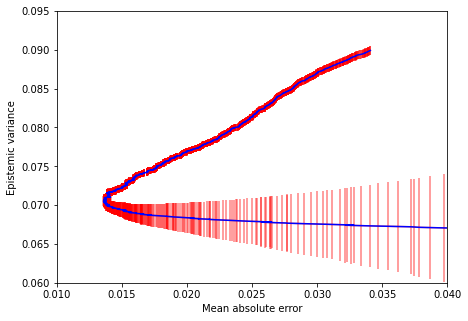

In [164]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(test_data["cu_mae"], test_data["cu_var"], zorder = 2, color = 'b')

errorbars = test_data["dummy"].cumsum()
ax.errorbar(test_data["cu_mae"], test_data["cu_var"], 
            yerr = test_data["cu_mae"] / np.sqrt(test_data["dummy"].cumsum()),
           color = 'r', zorder = 1, alpha = 0.5
           )

ax.set_xlabel("Mean absolute error")
ax.set_ylabel("Epistemic variance")

ax.set_xlim([0.01, 0.04])
ax.set_ylim([0.06, 0.095])

In [165]:
obs = test_data.sort_values("error", ascending = True).copy()
obs["mae_cov"] = 1 - obs["dummy"].cumsum() / len(obs)

In [166]:
h, b1, b2, _ = ax.hist2d(obs["var_cov"], obs["mae_cov"], bins = 20)

Text(0, 0.5, 'Observed confidence percentile (mae)')

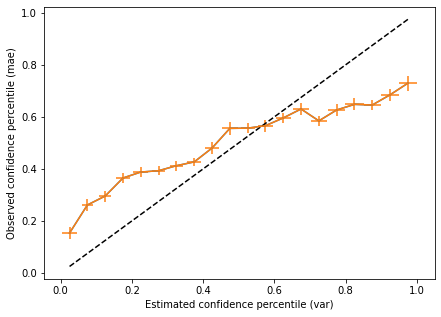

In [171]:
cov_var = np.arange(0.025, 1.025, 0.05)
cov_mae = [np.average(cov_var, weights = hi) for hi in h]
cov_mae_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]
cov_var_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h.T]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cov_var, cov_mae)
ax.errorbar(cov_var, cov_mae, xerr = cov_var_std, yerr = cov_mae_std)
ax.plot(cov_var, cov_var, 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (mae)")

#ax.set_xlim([0,1])
#ax.set_ylim([0,1])

In [168]:
np.abs(cov_var-cov_mae).mean()

0.1263129177564662